Outline

    initialization
        create 1D array of agents (X, Y, angle, W)
        create 2D/3D trace grid (empty)
        create 2D/3D dual deposit grid (empty)

    simulation
        update state
        draw GUI
        process data (kernel inputs: data, deposit)
        propagation step (kernel inputs: agents, trace, deposit)
        relaxation step (kernel inputs: deposit)
        relaxation step (kernel inputs: trace)
        generate visualization (kernel inputs: deposit, trace, vis buffer)
        update GUI

    store grids
    tidy up

In [1]:
import numpy as np
from enum import Enum
from enum import IntEnum
from numpy.random import default_rng
import time
from datetime import datetime
import matplotlib.pyplot as plt
import taichi as ti

## Default root directory
ROOT = 'c:/UCSC/Projects/PolyPhy/repo/PolyPhy/'

## Sampling strategy for agent directions
class EnumDirectionalSamplingType(IntEnum):
    DETERMINISTIC = 0
    STOCHASTIC = 1
directional_sampling_type = EnumDirectionalSamplingType.STOCHASTIC

## Deposit fetching strategy
class EnumDepositFetchingStrategy(IntEnum):
    NN = 0
    NN_PERTURBED = 1
deposit_fetching_strategy = EnumDepositFetchingStrategy.NN_PERTURBED

## Simulation-wide constants
N_AGENTS = 1000000
N_DATA = 1000
DOMAIN_SCALE = 100.0
TRACE_RESOLUTION = (1024, 1024)
DEPOSIT_DOWNSCALING_FACTOR = 1

DEPOSIT_RESOLUTION = (TRACE_RESOLUTION[0] // DEPOSIT_DOWNSCALING_FACTOR, TRACE_RESOLUTION[1] // DEPOSIT_DOWNSCALING_FACTOR)
DOMAIN_SIZE = (DOMAIN_SCALE, DOMAIN_SCALE * np.float32(TRACE_RESOLUTION[1]) / np.float32(TRACE_RESOLUTION[0]))
VIS_RESOLUTION = TRACE_RESOLUTION

## Type aliases
FLOAT_CPU = np.float32
INT_CPU = np.int32
FLOAT_GPU = ti.f32
INT_GPU = ti.i32

VEC2i = ti.types.vector(2, INT_GPU)
VEC3i = ti.types.vector(2, INT_GPU)
VEC2f = ti.types.vector(2, FLOAT_GPU)
VEC3f = ti.types.vector(3, FLOAT_GPU)

## Initializations
ti.init(arch=ti.gpu, dynamic_index=True)
rng = default_rng()

print('Number of agents:', N_AGENTS)
print('Number of data points:', N_DATA)
print('Trace grid resolution:', TRACE_RESOLUTION)
print('Deposit grid resolution:', DEPOSIT_RESOLUTION)
print('Simulation domain size:', DOMAIN_SIZE)

[Taichi] version 1.0.3, llvm 10.0.0, commit fae94a21, win, python 3.6.12
[Taichi] Starting on arch=cuda
Number of agents: 1000000
Number of data points: 1000
Trace grid resolution: (1024, 1024)
Deposit grid resolution: (1024, 1024)
Simulation domain size: (100.0, 100.0)


In [2]:
## Initialize data and agents randomly
## TODO data loading
## TODO more meaningful initialization of agents around data
data = np.zeros(shape=(N_DATA, 3), dtype = FLOAT_CPU)
data[:, 0] = rng.normal(loc = 0.5 * DOMAIN_SIZE[0], scale = 0.2 * DOMAIN_SIZE[0], size = N_DATA)
data[:, 1] = rng.normal(loc = 0.5 * DOMAIN_SIZE[1], scale = 0.2 * DOMAIN_SIZE[1], size = N_DATA)
data[:, 2] = 1000.0
print('Data sample:', data[0, :])
agents = np.zeros(shape=(N_AGENTS, 4), dtype = FLOAT_CPU)
agents[:, 0] = rng.uniform(low = 0.0, high = DOMAIN_SIZE[0], size = N_AGENTS)
agents[:, 1] = rng.uniform(low = 0.0, high = DOMAIN_SIZE[1], size = N_AGENTS)
agents[:, 2] = rng.uniform(low = 0.0, high = 2.0 * np.pi, size = N_AGENTS)
agents[:, 3] = 1.0
print('Agent sample:', agents[0, :])

Data sample: [  56.705143   17.987196 1000.      ]
Agent sample: [70.12416   62.594704   2.2371259  1.       ]


In [3]:
## Allocate GPU memory fields
data_field = ti.Vector.field(n = 3, dtype = FLOAT_GPU, shape = N_DATA)
agents_field = ti.Vector.field(n = 4, dtype = FLOAT_GPU, shape = N_AGENTS)
deposit_field = ti.Vector.field(n = 2, dtype = FLOAT_GPU, shape = DEPOSIT_RESOLUTION)
trace_field = ti.Vector.field(n = 1, dtype = FLOAT_GPU, shape = TRACE_RESOLUTION)
vis_field = ti.Vector.field(n = 3, dtype = FLOAT_GPU, shape = VIS_RESOLUTION)
print('Total GPU memory allocated:', INT_CPU(4 * (\
    data_field.shape[0] * 3 + \
    agents_field.shape[0] * 4 + \
    deposit_field.shape[0] * deposit_field.shape[1] * 2 + \
    trace_field.shape[0] * trace_field.shape[1] * 1 + \
    vis_field.shape[0] * vis_field.shape[1] * 3 \
    ) / 2 ** 20), 'MB')

Total GPU memory allocated: 39 MB


In [4]:
## Define all GPU kernels and functions
@ti.kernel
def zero_field(f: ti.template()):
    for cell in ti.grouped(f):
        f[cell].fill(0.0)
    return

@ti.kernel
def copy_field(dst: ti.template(), src: ti.template()): 
    for cell in ti.grouped(dst):
        dst[cell] = src[cell]
    return

@ti.func
def world_to_grid_2D(pos_world, size_world, size_grid) -> VEC2i:
    grid_coord = ti.cast((pos_world / size_world) * ti.cast(size_grid, FLOAT_GPU), INT_GPU)
    return ti.max(VEC2i(0, 0), ti.min(grid_coord, size_grid))

@ti.func
def angle_to_dir_2D(angle) -> VEC2f:
    return VEC2f(ti.cos(angle), ti.sin(angle))

@ti.func
def custom_mod(a, b) -> FLOAT_GPU:
    return a - b * ti.floor(a / b)

@ti.kernel
def data_step(weight_multiplier: FLOAT_GPU, current_deposit_index: INT_GPU):
    for point in ti.ndrange(data_field.shape[0]):
        pos = VEC2f(0.0, 0.0)
        pos[0], pos[1], weight = data_field[point]
        deposit_cell = world_to_grid_2D(pos, VEC2f(DOMAIN_SIZE), VEC2i(DEPOSIT_RESOLUTION))
        deposit_field[deposit_cell][current_deposit_index] += weight_multiplier * ti.abs(weight)
    return

@ti.kernel
def propagation_step(sense_distance: FLOAT_GPU,\
                    sense_angle: FLOAT_GPU,\
                    steering_rate: FLOAT_GPU,\
                    step_size: FLOAT_GPU,\
                    weight_multiplier: FLOAT_GPU,\
                    current_deposit_index: INT_GPU,\
                    directional_sampling_type: INT_GPU,\
                    deposit_fetching_strategy: INT_GPU):
    for agent in ti.ndrange(agents_field.shape[0]):
        pos = VEC2f(0.0, 0.0)
        pos[0], pos[1], angle, weight = agents_field[agent]
        
        dir_fwd = angle_to_dir_2D(angle)
        angle_mut = angle + (ti.random(dtype=FLOAT_GPU) - 0.5) * sense_angle
        dir_mut = angle_to_dir_2D(angle_mut)

        deposit_fwd = 0.0
        deposit_mut = 0.0
        if deposit_fetching_strategy == EnumDepositFetchingStrategy.NN:
            deposit_fwd = deposit_field[world_to_grid_2D(pos + sense_distance * dir_fwd, VEC2f(DOMAIN_SIZE), VEC2i(DEPOSIT_RESOLUTION))][current_deposit_index]
            deposit_mut = deposit_field[world_to_grid_2D(pos + sense_distance * dir_mut, VEC2f(DOMAIN_SIZE), VEC2i(DEPOSIT_RESOLUTION))][current_deposit_index]
        elif deposit_fetching_strategy == EnumDepositFetchingStrategy.NN_PERTURBED:
            field_dd = 0.5 * ti.cast(DOMAIN_SIZE[0], FLOAT_GPU) / ti.cast(DEPOSIT_RESOLUTION[0], FLOAT_GPU)
            pos_fwd = pos + sense_distance * dir_fwd + (field_dd * ti.random(dtype=FLOAT_GPU) * angle_to_dir_2D(360.0 * ti.random(dtype=FLOAT_GPU)))
            deposit_fwd = deposit_field[world_to_grid_2D(pos_fwd, VEC2f(DOMAIN_SIZE), VEC2i(DEPOSIT_RESOLUTION))][0]
            pos_mut = pos + sense_distance * dir_mut + (field_dd * ti.random(dtype=FLOAT_GPU) * angle_to_dir_2D(360.0 * ti.random(dtype=FLOAT_GPU)))
            deposit_mut = deposit_field[world_to_grid_2D(pos_mut, VEC2f(DOMAIN_SIZE), VEC2i(DEPOSIT_RESOLUTION))][0]

        angle_new = 0.0
        if directional_sampling_type == EnumDirectionalSamplingType.DETERMINISTIC:
            angle_new = (angle) if (deposit_fwd > deposit_mut) else (steering_rate * angle_mut + (1.0-steering_rate) * angle)
        elif directional_sampling_type == EnumDirectionalSamplingType.STOCHASTIC:
            angle_new = (angle) if (ti.random(dtype=FLOAT_GPU) < deposit_fwd / (deposit_fwd + deposit_mut)) else (steering_rate * angle_mut + (1.0-steering_rate) * angle)
        dir_new = angle_to_dir_2D(angle_new)
        pos_new = pos + step_size * dir_new

        pos_new[0] = custom_mod(pos_new[0], DOMAIN_SIZE[0])
        pos_new[1] = custom_mod(pos_new[1], DOMAIN_SIZE[1])

        agents_field[agent][0] = pos_new[0]
        agents_field[agent][1] = pos_new[1]
        agents_field[agent][2] = angle_new

        deposit_cell = world_to_grid_2D(pos_new, VEC2f(DOMAIN_SIZE), VEC2i(DEPOSIT_RESOLUTION))
        deposit_field[deposit_cell][current_deposit_index] += weight_multiplier * weight

        trace_cell = world_to_grid_2D(pos_new, VEC2f(DOMAIN_SIZE), VEC2i(TRACE_RESOLUTION))
        trace_field[trace_cell][0] += weight_multiplier * weight
    return

DIFFUSION_KERNEL = [1.0, 1.0, 0.707]
DIFFUSION_KERNEL_NORM = DIFFUSION_KERNEL[0] + 4.0 * DIFFUSION_KERNEL[1] + 4.0 * DIFFUSION_KERNEL[2]

@ti.kernel
def relaxation_step_deposit(attenuation: FLOAT_GPU, diffusion_resistance: FLOAT_GPU, current_deposit_index: INT_GPU):
    for cell in ti.grouped(deposit_field):
        value = (DIFFUSION_KERNEL[0] + diffusion_resistance) * deposit_field[cell + ( 0, 0)][current_deposit_index]\
               + DIFFUSION_KERNEL[1]                         * deposit_field[cell + (-1, 0)][current_deposit_index]\
               + DIFFUSION_KERNEL[1]                         * deposit_field[cell + ( 1, 0)][current_deposit_index]\
               + DIFFUSION_KERNEL[1]                         * deposit_field[cell + ( 0,-1)][current_deposit_index]\
               + DIFFUSION_KERNEL[1]                         * deposit_field[cell + ( 0, 1)][current_deposit_index]\
               + DIFFUSION_KERNEL[2]                         * deposit_field[cell + (-1,-1)][current_deposit_index]\
               + DIFFUSION_KERNEL[2]                         * deposit_field[cell + ( 1, 1)][current_deposit_index]\
               + DIFFUSION_KERNEL[2]                         * deposit_field[cell + ( 1,-1)][current_deposit_index]\
               + DIFFUSION_KERNEL[2]                         * deposit_field[cell + (-1, 1)][current_deposit_index]
        deposit_field[cell][1 - current_deposit_index] = attenuation * value / (DIFFUSION_KERNEL_NORM + diffusion_resistance)
    return

@ti.kernel
def relaxation_step_trace(attenuation: FLOAT_GPU):
    for cell in ti.grouped(trace_field):
        trace_field[cell][0] *= attenuation
    return

@ti.kernel
def render_visualization(current_deposit_index: INT_GPU):
    for x, y in ti.ndrange(vis_field.shape[0], vis_field.shape[1]):
        deposit_val = deposit_field[x * DEPOSIT_RESOLUTION[0] // VIS_RESOLUTION[0], y * DEPOSIT_RESOLUTION[1] // VIS_RESOLUTION[1]][current_deposit_index]
        trace_val = trace_field[x * TRACE_RESOLUTION[0] // VIS_RESOLUTION[0], y * TRACE_RESOLUTION[1] // VIS_RESOLUTION[1]]
        vis_field[x, y] = VEC3f(trace_val, deposit_val, 0.0)
    return

In [5]:
## Initialize GPU fields
data_field.from_numpy(data)
agents_field.from_numpy(agents)
zero_field(deposit_field)
zero_field(trace_field)
zero_field(vis_field)

In [6]:
## Main simulation & vis loop
sense_distance = 2.0
sense_angle = 3.0
step_size = 0.2
deposit_attenuation = 0.9
deposit_resistance = 10.0
trace_attenuation = 0.98
weight_multiplier = 0.05
steering_rate = 0.5

current_deposit_index = 0
data_edit_index = 0

window = ti.ui.Window('PolyPhy', (vis_field.shape[0], vis_field.shape[1]), show_window = True)
canvas = window.get_canvas()

def edit_data(edit_index: INT_CPU) -> INT_CPU:
    mouse_rel_pos = window.get_cursor_pos()
    mouse_pos = mouse_rel_pos * FLOAT_CPU(DOMAIN_SIZE)
    data[edit_index, 0:2] = mouse_pos
    data_field.from_numpy(data)
    edit_index = (edit_index + 1) % N_DATA
    return edit_index

while window.running:
    do_quit = False
    do_screenshot = False

    if window.get_event(ti.ui.PRESS):
        if window.event.key == 's': do_screenshot = True
        elif window.event.key in [ti.ui.ESCAPE]: do_quit = True
        elif window.event.key in [ti.ui.LMB]:
            data_edit_index = edit_data(data_edit_index)
    if window.is_pressed(ti.ui.RMB):
        data_edit_index = edit_data(data_edit_index)
    
    window.GUI.begin('Main', 0.01, 0.01, 0.3, 0.3)

    window.GUI.text("MCPM parameters:")
    sense_distance = window.GUI.slider_float('Sense dist', sense_distance, 0.1, 10.0)
    sense_angle = window.GUI.slider_float('Sense angle', sense_angle, 0.1, 10.0)
    step_size = window.GUI.slider_float('Step size', step_size, 0.01, 0.5)
    deposit_attenuation = window.GUI.slider_float('Deposit attn', deposit_attenuation, 0.8, 0.999)
    deposit_resistance = window.GUI.slider_float('Deposit resist', deposit_resistance, 0.0, 100.0)
    trace_attenuation = window.GUI.slider_float('Trace attn', trace_attenuation, 0.9, 0.999)
    weight_multiplier = window.GUI.slider_float('Weight coef', weight_multiplier, 0.001, 0.1)

    window.GUI.text("Directional sampling:")
    if window.GUI.checkbox("Deterministic", directional_sampling_type == EnumDirectionalSamplingType.DETERMINISTIC):
        directional_sampling_type = EnumDirectionalSamplingType.DETERMINISTIC
    if window.GUI.checkbox("Stochastic", directional_sampling_type == EnumDirectionalSamplingType.STOCHASTIC):
        directional_sampling_type = EnumDirectionalSamplingType.STOCHASTIC

    window.GUI.text("Deposit fetching:")
    if window.GUI.checkbox("Nearest neighbor", deposit_fetching_strategy == EnumDepositFetchingStrategy.NN):
        deposit_fetching_strategy = EnumDepositFetchingStrategy.NN
    if window.GUI.checkbox("Noise-perturbed NN", deposit_fetching_strategy == EnumDepositFetchingStrategy.NN_PERTURBED):
        deposit_fetching_strategy = EnumDepositFetchingStrategy.NN_PERTURBED

    window.GUI.text("Misc controls:")
    do_screenshot = do_screenshot | window.GUI.button('Screenshot')
    do_quit = do_quit | window.GUI.button('Quit')
    window.GUI.end()

    data_step(weight_multiplier, current_deposit_index)
    propagation_step(sense_distance, sense_angle, steering_rate, step_size, weight_multiplier, current_deposit_index, directional_sampling_type, deposit_fetching_strategy)
    relaxation_step_deposit(deposit_attenuation, deposit_resistance, current_deposit_index)
    relaxation_step_trace(trace_attenuation)
    current_deposit_index = 1 - current_deposit_index

    render_visualization(current_deposit_index)
    canvas.set_image(vis_field)

    if do_screenshot:
        window.write_image(ROOT + 'capture/screenshot_' + datetime.fromtimestamp(time.time()).strftime("%Y-%m-%d_%H-%M-%S") + '.png')
    window.show()
    if do_quit:
        break

window.destroy()
deposit = deposit_field.to_numpy()
trace = trace_field.to_numpy()

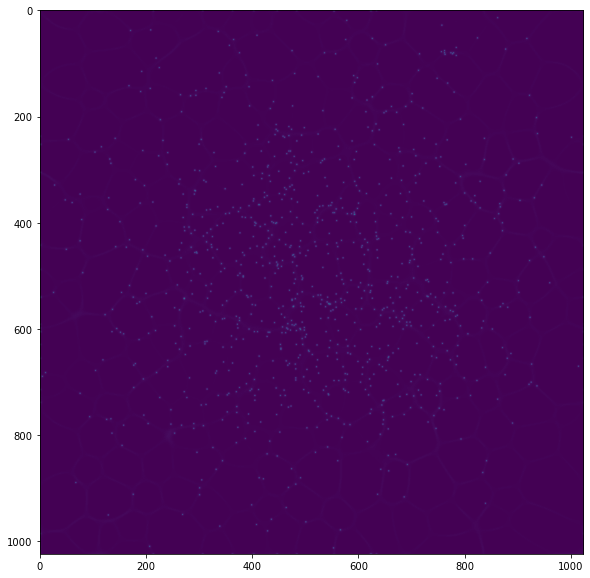

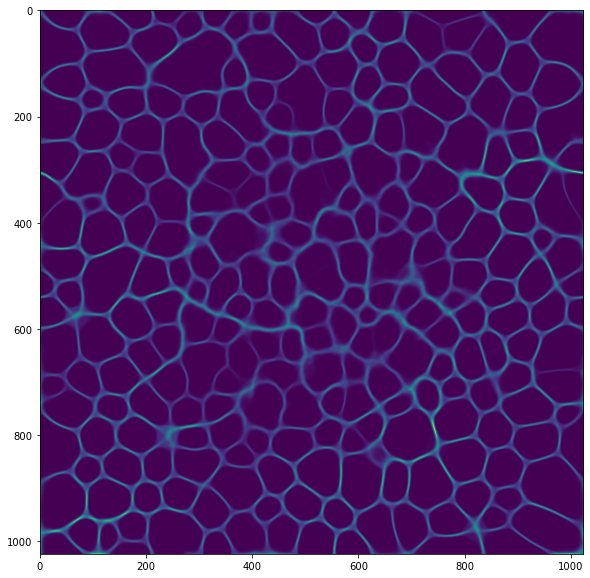

: 

In [7]:
## Plot results
plt.figure(figsize = (10.0, 10.0))
plt.imshow(deposit[:,:,0])
plt.figure(figsize = (10.0, 10.0))
plt.imshow(trace)